## ch14 Do you have enough data
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.8.4</div>
<div style="text-align: right"> Last update: 2023.8.4</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp
from xg_helpers import my_dot_export

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

충분한 데이터를 가지고 있으면 오버피팅 개선에 도움된다.  
오버피팅은 모델이 노이즈나 학습데이터에서 관련이 없는 디테일을 학습할 때 발생한다. 이는 일반화 성능을 저해한다.

### 14.1 Learning Curves

학습 곡선은 머신러닝 모델의 성능과 모델 학습에 사용된 데이터의 양 사이의 관계를 그래픽으로 표현한 것입니다.  
증가하는 데이터 양에 따라 모델을 학습시키고 그 과정에서 점수를 그래프로 표시합니다.  
학습 곡선의 X축은 학습 예제 수 또는 학습 데이터의 양을 나타내고, Y축은 오류율, 정확도 또는 F1 점수와 같은 모델의 성능 메트릭을 나타냅니다. 


Yellowbrick 라이브러리에는 학습 곡선 시각화 기능이 포함되어 있습니다.  
결과를 일관성 있게 전달하기 위해 모든 학습 곡선 플롯에 대해 y-한계를 수동으로 설정하고 있습니다. 

그렇지 않으면 플롯에서 아래쪽 부분이 잘려서 이미지가 잘리고 성능이 좋은 모델이 성능이 나쁜 것처럼 보이게 됩니다.

In [9]:
params = {'learning_rate': 0.3,
'max_depth': 2,
'n_estimators': 200,
'n_jobs': -1,
'random_state': 42,
'reg_lambda': 0,
'subsample': 1}

In [10]:
import yellowbrick.model_selection as ms

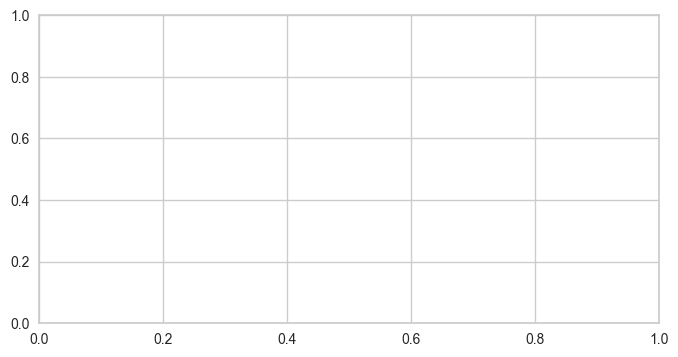

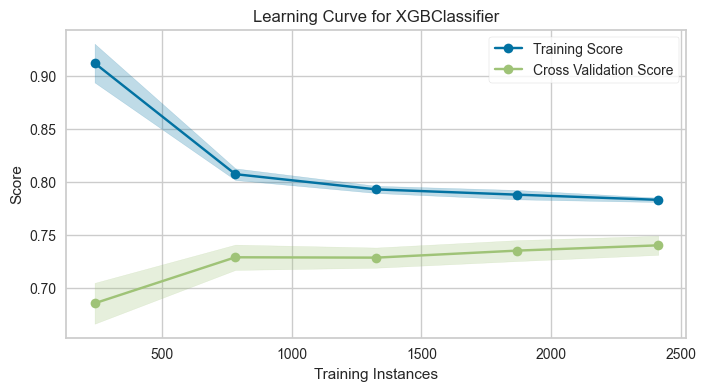

(0.6, 1.0)

In [11]:
fig, ax = plt.subplots(figsize = (8, 4))

fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(xgb.XGBClassifier(**params),
X, y, ax=ax
)
ax.set_ylim(0.6, 1)

- 학습 데이터의 양이 증가함에 따라 모델의 교차 검증(테스트) 성능이 일관되고 단조롭게 향상됨을 나타냅니다. 즉, 훈련 예제 수나 훈련 데이터의 양이 증가함에 따라 모델의 오류율이나 정확도가 감소한다는 것을 의미합니다. 교차 검증 점수가 정체된 것 같지 않기 때문에 데이터를 더 추가하면 더 좋은 모델을 만들 수 있을 것 같습니다.

- 데이터의 기본 패턴과 추세를 학습하고 학습 데이터에 과적합하거나 과소적합하지 않은지 확인합니다. 과적합 모델은 훈련 점수가 100%에 가까운 정확도를 보일 것입니다. 우리는 테스트 데이터로 내려오는 것을 보고 싶습니다. 또한 교차 검증 점수가 훈련 점수에 근접한 추세를 보이는 것도 좋습니다.  

- 따라서 오버피팅이 아니며 데이터가 늘어날수록 성능이 늘어날 수도 있다.

### 14.2 Learning Curves for Decision Trees

이제 max_depth가 7인 결정 트리를 그려보자.

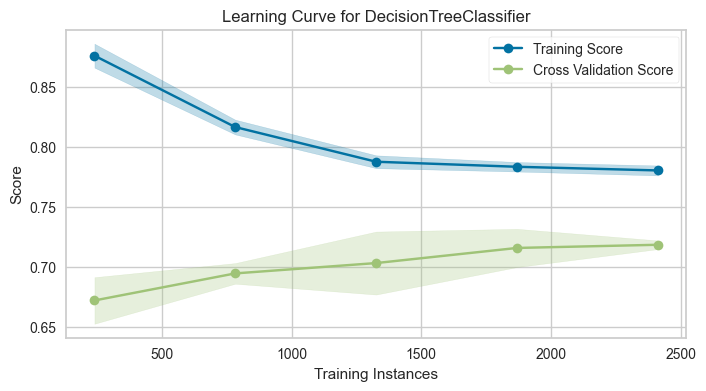

(0.6, 1.0)

In [12]:
# tuned tree
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(max_depth=7),
X, y, ax=ax)
viz.ax.set_ylim(0.6, 1)

- 이 또한 데이터가 추가되면 성능이 좋아질 것 같다.

### 14.3 Underfit Learning Curves

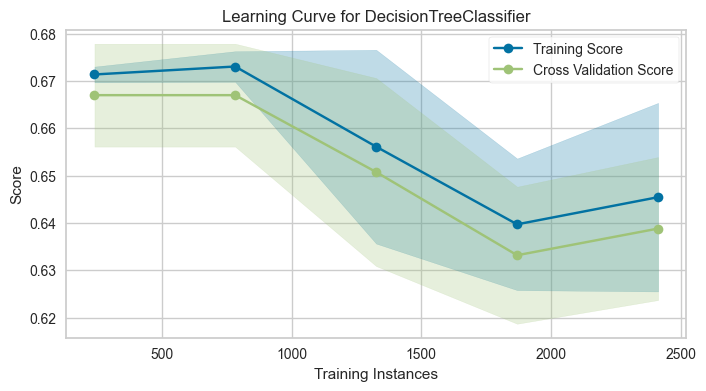

(0.6, 1.0)

In [13]:
# underfit
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(max_depth=1),
X, y, ax=ax
)
ax.set_ylim(0.6, 1)

### 14.4 Overfit Learning Curves

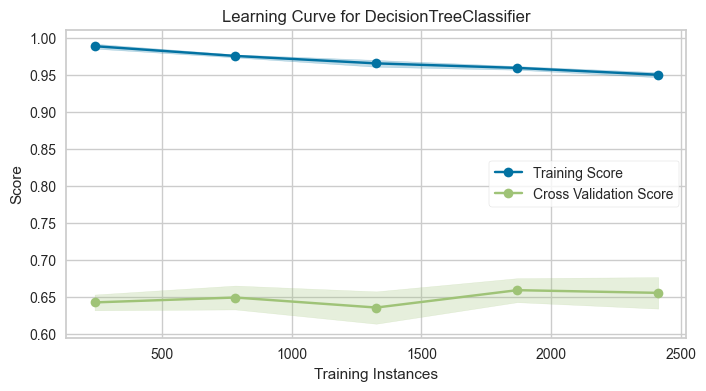

(0.6, 1.0)

In [14]:
# overfit
fig, ax = plt.subplots(figsize=(8, 4))
viz = ms.learning_curve(tree.DecisionTreeClassifier(),
      X, y, ax=ax
)
ax.set_ylim(0.6, 1)